In [1]:
from IPython.core.display import display, HTML
import math
import pandas as pd

import mlos.global_values as global_values
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Spaces import ContinuousDimension, Point, SimpleHypergrid
from mlos.Tracer import Tracer

display(HTML("<style>.container { width:100% !important; }</style>"))

global_values.declare_singletons()
global_values.tracer = Tracer(actor_id="MetaOptimizer", thread_id=0)

# Let's stand up the Optimizer Microservice
#
optimizer_factory = BayesianOptimizerFactory()

In [2]:
# Let's make a meta optimizer.
#
meta_optimizer_config = bayesian_optimizer_config_store.get_config_by_name("default_with_glow_worm")
meta_optimizer_config.homogeneous_random_forest_regression_model_config.n_estimators = 100
meta_optimizer_config.homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.n_new_samples_before_refit = 1
meta_optimizer_config.experiment_designer_config.fraction_random_suggestions = 0.2

meta_optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=meta_optimizer_config,
    optimization_problem=OptimizationProblem(
        parameter_space=bayesian_optimizer_config_store.parameter_space,
        objective_space=SimpleHypergrid(
            name="predictions",
            dimensions=[
                ContinuousDimension(name="optimum_value_after_100_iterations", min=-math.inf, max=math.inf)
            ]
        ),
        objectives=[Objective(name='optimum_value_after_100_iterations', minimize=True)]
    )
)

09/29/2020 19:08:40 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 100,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mo

In [3]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory
from mlos.OptimizerEvaluationTools.ObjectiveFunctionConfigStore import objective_function_config_store
objective_function_config = objective_function_config_store.get_config_by_name('three_level_quadratic')
objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)

print(objective_function_config.to_json(indent=2))

{
  "implementation": "ThreeLevelQuadratic"
}


In [4]:
print(objective_function.parameter_space)

  Name: three_level_quadratic_config
  Dimensions:
    vertex_height: {low, 5, 15}

  IF vertex_height IN {15} THEN (
    Name: high_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {5} THEN (
    Name: medium_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {low} THEN (
    Name: low_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )


In [5]:
from mlos.Logger import create_logger
from mlos.Optimizers.RegressionModels.RegressionModelFitState import RegressionModelFitState

# Let us set up the lists to track optima over time.
#
best_observation_num_observations = []
best_observation_configs = []
best_observations = []

predicted_value_num_observations = []
best_predicted_value_configs = []
best_predicted_values = []

regression_model_fit_state = RegressionModelFitState()

In [6]:
logger = create_logger("Optimizer evaluation.")
outer_loop_iteration = 0

In [ ]:
from mlos.Optimizers.OptimumDefinition import OptimumDefinition
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import GoodnessOfFitMetrics, DataSetType



start_iteration_num = outer_loop_iteration
end_iteration_num = start_iteration_num + 50

for outer_loop_iteration in range(start_iteration_num, end_iteration_num):
    inner_optimizer_config = meta_optimizer.suggest()
    
    inner_optimizer = optimizer_factory.create_local_optimizer(
        optimizer_config=inner_optimizer_config,
        optimization_problem=OptimizationProblem(
            parameter_space=objective_function.parameter_space,
            objective_space=objective_function.output_space,
            objectives=[Objective(name='y', minimize=True)]
        )
    )
    
    ############################################# INNER OPTIMIZATION #############################################
    
    try:
        for i in range(100):
            parameters = inner_optimizer.suggest()
            objectives = objective_function.evaluate_point(parameters)
            logger.info(f"[{i+1}/{100}]Parameters: {parameters}, objectives: {objectives}")
            inner_optimizer.register(feature_values_pandas_frame=parameters.to_dataframe(), target_values_pandas_frame=objectives.to_dataframe())
        best_observation_config, best_observation = inner_optimizer.optimum(OptimumDefinition.BEST_OBSERVATION)
        
        logger.info(f"[{outer_loop_iteration+1}/{end_iteration_num}] {best_observation}")
        meta_optimizer.register(feature_values_pandas_frame=inner_optimizer_config.to_dataframe(), target_values_pandas_frame=Point(optimum_value_after_100_iterations=best_observation.y).to_dataframe())
    
    except:
        logger.error("Failed to complete inner optimization.", exc_info=True)
    
    ############################################# INNER OPTIMIZATION #############################################
    
    
    if meta_optimizer.trained:
        gof_metrics = meta_optimizer.compute_surrogate_model_goodness_of_fit()
        regression_model_fit_state.set_gof_metrics(data_set_type=DataSetType.TRAIN, gof_metrics=gof_metrics)
        
    best_observation_num_observations.append(outer_loop_iteration)
    
    best_observation_config, best_observation = meta_optimizer.optimum(OptimumDefinition.BEST_OBSERVATION)    
    best_observation_configs.append(best_observation_config)
    best_observations.append(best_observation)
    
    try:
        best_predicted_value_config, best_predicted_value = meta_optimizer.optimum(OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG)
        best_predicted_value_configs.append(best_predicted_value_config)
        best_predicted_values.append(best_predicted_value)
        predicted_value_num_observations.append(outer_loop_iteration)
    except:
        pass
    

09/29/2020 19:28:48 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 79,
  "homogeneous_random_forest_regression_model_config.n_estimators": 59,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 0.6512813708042503,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.08512427884965224,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.bootstrap": 1,
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "friedman_mse",
  "homogeneous_random_forest_regression_m

09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [19/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 87.66366448493346, "high_quadratic_params.x_2": 10.179823876858848}, objectives: {"y": 7803.54688509085}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [20/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -64.38756252436372, "high_quadratic_params.x_2": -53.062198980938334}, objectives: {"y": 6976.355168521541}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [21/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -78.7471540937952, "high_quadratic_params.x_2": -70.77017086637557}, objectives: {"y": 11224.53136232792}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-inpu

09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [46/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 76.8323542310232, "high_quadratic_params.x_2": 10.19930044008342}, objectives: {"y": 6022.236386148515}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [47/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 87.1641090744528, "high_quadratic_params.x_2": 4.912817300807461}, objectives: {"y": 7636.717684574218}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [48/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -43.223218569073296, "high_quadratic_params.x_2": 43.64960628866535}, objectives: {"y": 3788.5347526253768}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-3

09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [73/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -18.213120164378154, "high_quadratic_params.x_2": 98.5267500658081}, objectives: {"y": 10054.238224652296}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [74/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -7.2882753797685496, "low_quadratic_params.x_2": -75.29307459233877}, objectives: {"y": 5722.16603957883}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [75/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 50.49403052903352, "low_quadratic_params.x_2": -92.04890562868948}, objectives: {"y": 11022.648146506352}
09/29/2020 19:28:48 -      Optimizer evaluation. -    INFO - [<ipython-

09/29/2020 19:29:36 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [100/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -38.271914065163394, "low_quadratic_params.x_2": -80.29679849928138}, objectives: {"y": 7912.315255445448}
09/29/2020 19:29:36 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  31 -                  <module>() ] [28/77] {"y": 17.23071924466425}
09/29/2020 19:30:06 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 70,
  "homogeneous_random_forest_regression_model_config.n_estimators": 36,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_es

09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [17/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 39.061352679620455, "medium_quadratic_params.x_2": 91.11211952224343}, objectives: {"y": 9832.207596997265}
09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [18/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -88.72898508758938, "low_quadratic_params.x_2": 39.64813063037096}, objectives: {"y": 9444.807057156619}
09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [19/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 20.371273623823626, "low_quadratic_params.x_2": 7.422309205026949}, objectives: {"y": 470.07946299171994}
09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [44/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -60.867513972803366, "high_quadratic_params.x_2": -31.421478219032366}, objectives: {"y": 4707.1635506985385}
09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [45/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -15.775487930234775, "medium_quadratic_params.x_2": -28.571480813055786}, objectives: {"y": 1070.195535287798}
09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [46/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -60.693702995898136, "low_quadratic_params.x_2": -41.64859179400355}, objectives: {"y": 5418.330781777834}
09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<

09/29/2020 19:30:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [71/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -87.61436839204802, "high_quadratic_params.x_2": -93.076587756113}, objectives: {"y": 16354.528737058909}
09/29/2020 19:30:08 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [72/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 75.09752645267534, "low_quadratic_params.x_2": -64.14721611314712}, objectives: {"y": 9754.503814377074}
09/29/2020 19:30:10 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [73/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -48.25799712278682, "medium_quadratic_params.x_2": -12.222154625833099}, objectives: {"y": 2483.215350000674}
09/29/2020 19:30:11 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 19:30:38 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [98/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 32.69545778042283, "high_quadratic_params.x_2": -86.89922666219418}, objectives: {"y": 8635.468553958812}
09/29/2020 19:30:39 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [99/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 53.04131335509027, "medium_quadratic_params.x_2": -5.126443239513463}, objectives: {"y": 2844.6613427208304}
09/29/2020 19:30:39 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [100/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 2.27232679979808, "high_quadratic_params.x_2": 76.1987885836212}, objectives: {"y": 5826.41885069648}
09/29/2020 19:30:39 -      Optimizer evaluation. -    INFO - [<ipython-inpu

09/29/2020 19:31:10 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [15/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 23.83257661169094, "medium_quadratic_params.x_2": -73.16153717658239}, objectives: {"y": 5925.602229992564}
09/29/2020 19:31:10 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [16/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -91.53578566496851, "high_quadratic_params.x_2": 75.06539441717646}, objectives: {"y": 14028.613496309323}
09/29/2020 19:31:10 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [17/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 96.3299335120503, "low_quadratic_params.x_2": 55.509497873628334}, objectives: {"y": 12360.76044461838}
09/29/2020 19:31:10 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:31:24 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [42/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -42.58522519690147, "high_quadratic_params.x_2": 50.85148917829463}, objectives: {"y": 4414.375356721027}
09/29/2020 19:31:26 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [43/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -49.25092672454012, "low_quadratic_params.x_2": -99.1138870248987}, objectives: {"y": 12249.216384410403}
09/29/2020 19:31:28 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [44/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -51.6391613793457, "low_quadratic_params.x_2": -53.72276202652979}, objectives: {"y": 5552.73814772126}
09/29/2020 19:31:29 -      Optimizer evaluation. -    INFO - [<ipython-inp

09/29/2020 19:32:01 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [69/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 39.64301259823779, "low_quadratic_params.x_2": 29.28933942284712}, objectives: {"y": 2429.4338516907865}
09/29/2020 19:32:03 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [70/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 93.58580530740625, "medium_quadratic_params.x_2": 25.339935227443064}, objectives: {"y": 9405.415272366758}
09/29/2020 19:32:05 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [71/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 67.54651811224483, "high_quadratic_params.x_2": -11.086032502220462}, objectives: {"y": 4700.4322257281065}
09/29/2020 19:32:05 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 19:32:41 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [96/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 25.803238965684244, "high_quadratic_params.x_2": -33.732885140493124}, objectives: {"y": 1818.7146810219074}
09/29/2020 19:32:42 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [97/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -15.566945352315358, "low_quadratic_params.x_2": -10.160702171419771}, objectives: {"y": 345.5696562182672}
09/29/2020 19:32:44 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [98/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 50.68516108848053, "low_quadratic_params.x_2": 82.84644229454798}, objectives: {"y": 9432.51855542909}
09/29/2020 19:32:46 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 19:32:51 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [10/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 44.58038756003094, "low_quadratic_params.x_2": -65.87433271770578}, objectives: {"y": 6326.838666005564}
09/29/2020 19:32:51 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [11/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -42.7320993861624, "low_quadratic_params.x_2": 58.42332401026127}, objectives: {"y": 5239.317106356832}
09/29/2020 19:32:51 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [12/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 94.26380882364606, "low_quadratic_params.x_2": -15.260767577441143}, objectives: {"y": 9118.556680993572}
09/29/2020 19:32:51 -      Optimizer evaluation. -    INFO - [<ipython-in

09/29/2020 19:32:52 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [37/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 65.56226411115139, "high_quadratic_params.x_2": -43.95982054183636}, objectives: {"y": 6245.876297450828}
09/29/2020 19:32:52 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [38/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 56.619804570079566, "medium_quadratic_params.x_2": 8.367500981238706}, objectives: {"y": 3280.817342225034}
09/29/2020 19:32:52 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [39/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -10.263067474497191, "low_quadratic_params.x_2": 77.84924507696581}, objectives: {"y": 6165.8355130395685}
09/29/2020 19:32:52 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 19:32:53 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [64/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 91.68223643971436, "high_quadratic_params.x_2": 57.6279228913572}, objectives: {"y": 11741.6099753599}
09/29/2020 19:32:53 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [65/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 12.126657551111663, "low_quadratic_params.x_2": 51.20588410138092}, objectives: {"y": 2769.0983899659886}
09/29/2020 19:32:54 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [66/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -92.84637151858995, "medium_quadratic_params.x_2": -80.07527053976759}, objectives: {"y": 15037.497656185002}
09/29/2020 19:32:54 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:32:55 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [91/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 77.47462802627254, "high_quadratic_params.x_2": 61.96367301464022}, objectives: {"y": 9856.814761274547}
09/29/2020 19:32:55 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [92/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -46.02757266688285, "medium_quadratic_params.x_2": -88.99409101357065}, objectives: {"y": 10043.485680936878}
09/29/2020 19:32:55 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [93/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -17.470991250734542, "medium_quadratic_params.x_2": 23.880355600312498}, objectives: {"y": 880.5069188806194}
09/29/2020 19:32:55 -      Optimizer evaluation. -    INFO - [<ipyt

09/29/2020 19:33:00 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [5/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -35.88334320172362, "low_quadratic_params.x_2": 75.7681889011159}, objectives: {"y": 7028.432768687868}
09/29/2020 19:33:00 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [6/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -14.182025106340632, "medium_quadratic_params.x_2": 82.61037213380143}, objectives: {"y": 7030.603420202032}
09/29/2020 19:33:00 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [7/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -80.21415167102353, "high_quadratic_params.x_2": 98.8908441538112}, objectives: {"y": 16228.709185755342}
09/29/2020 19:33:01 -      Optimizer evaluation. -    INFO - [<ipython-inpu

09/29/2020 19:33:04 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [32/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 5.779688251833221, "medium_quadratic_params.x_2": 95.53528872744621}, objectives: {"y": 9165.396188524892}
09/29/2020 19:33:04 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [33/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -49.05045607201111, "low_quadratic_params.x_2": -79.37962916925832}, objectives: {"y": 8707.072767921258}
09/29/2020 19:33:04 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [34/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 50.56983412706197, "high_quadratic_params.x_2": 93.68714244425195}, objectives: {"y": 11349.588783008116}
09/29/2020 19:33:04 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:33:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [59/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -0.46326282147006737, "high_quadratic_params.x_2": 97.86947075406312}, objectives: {"y": 9593.647918122171}
09/29/2020 19:33:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [60/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -61.6807040999837, "high_quadratic_params.x_2": 1.1268367020511363}, objectives: {"y": 3820.779019222836}
09/29/2020 19:33:07 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [61/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 94.29377609767852, "medium_quadratic_params.x_2": 49.346394542949014}, objectives: {"y": 11331.382865147516}
09/29/2020 19:33:08 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 19:33:11 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [86/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -17.024298467591237, "low_quadratic_params.x_2": 44.91820561019654}, objectives: {"y": 2307.471933553521}
09/29/2020 19:33:11 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [87/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -29.469084092248153, "low_quadratic_params.x_2": -89.53753624802499}, objectives: {"y": 8885.397314602382}
09/29/2020 19:33:12 -      Optimizer evaluation. -    INFO - [<ipython-input-35-4fd5ad209f33>:  27 -                  <module>() ] [88/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 59.08300109322286, "high_quadratic_params.x_2": -6.715917917972149}, objectives: {"y": 3550.9045716627134}
09/29/2020 19:33:12 -      Optimizer evaluation. -    INFO - [<ipython

In [26]:
best_observation_config, best_observation

({"surrogate_model_implementation": "HomogeneousRandomForestRegressionModel", "experiment_designer_implementation": "ExperimentDesigner", "min_samples_required_for_guided_design_of_experiments": 23, "homogeneous_random_forest_regression_model_config.n_estimators": 74, "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 0.7033486829066963, "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.04590752984950508, "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel", "homogeneous_random_forest_regression_model_config.bootstrap": 0, "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mae", "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best", "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth": 602, "homogeneous_random_fore

In [27]:
best_predicted_value_config, best_predicted_value

({"surrogate_model_implementation": "HomogeneousRandomForestRegressionModel", "experiment_designer_implementation": "ExperimentDesigner", "min_samples_required_for_guided_design_of_experiments": 81, "homogeneous_random_forest_regression_model_config___n_estimators": 71, "homogeneous_random_forest_regression_model_config___features_fraction_per_estimator": 0.05401147461048483, "homogeneous_random_forest_regression_model_config___samples_fraction_per_estimator": 0.4616222936227359, "homogeneous_random_forest_regression_model_config___regressor_implementation": "DecisionTreeRegressionModel", "homogeneous_random_forest_regression_model_config___bootstrap": 0, "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___criterion": "mse", "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___splitter": "best", "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___max_depth": 409, "h

In [28]:
# Best observation dataframe
#
best_observation_df = pd.DataFrame([observation.to_dict() for observation in best_observations])
best_observation_df['num_observations'] = best_observation_num_observations
best_observation_df = pd.concat([best_observation_df.drop_duplicates(subset=['optimum_value_after_100_iterations'], keep='last'), best_observation_df.drop_duplicates(subset=['optimum_value_after_100_iterations'], keep='first')]).sort_index()

In [31]:
best_predicted_value_df = pd.DataFrame([predicted_value.to_dict() for predicted_value in best_predicted_values])
best_predicted_value_df['num_observations'] = predicted_value_num_observations
best_predicted_value_df = pd.concat([best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='last'), best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='first')]).sort_index()
best_predicted_value_df

,predicted_value,num_observations
0,68.495879,27
0,68.495879,27


C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


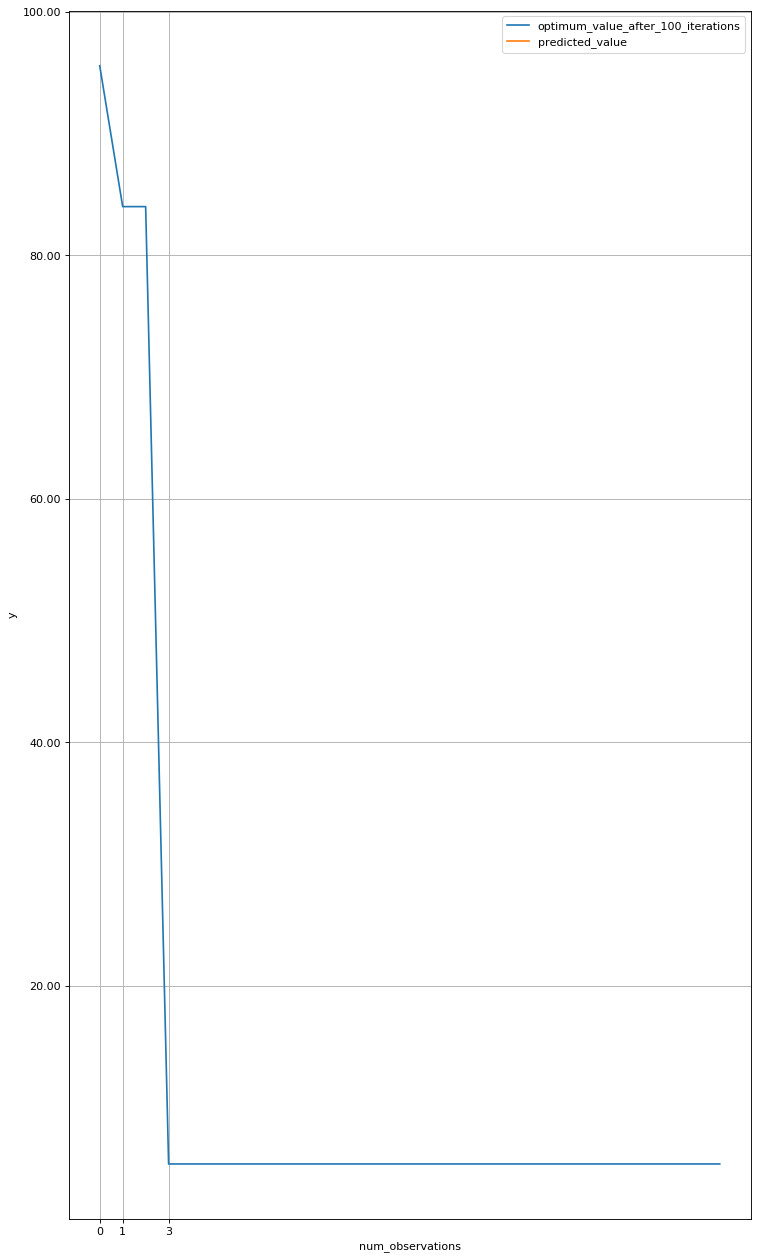

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

fig, axs = plt.subplots(1, figsize=(11, 20), dpi=80, sharex=True)

axs.plot(best_observation_df['num_observations'], best_observation_df['optimum_value_after_100_iterations'], label='optimum_value_after_100_iterations')
axs.plot(best_predicted_value_df['num_observations'], best_predicted_value_df['predicted_value'], label='predicted_value')
axs.set_ylabel('y')
axs.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
axs.set_xticks(best_observation_df['num_observations'][::2])
axs.grid(True)
axs.set_xlabel('num_observations')
axs.legend()  
fig.show()

In [32]:
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import DataSetType

# Let's take a look at goodness of fit data.
#
goodness_of_fit_dataframe = regression_model_fit_state.get_goodness_of_fit_dataframe(data_set_type=DataSetType.TRAIN) # TODO: add support to evaluate GoF on test data

C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


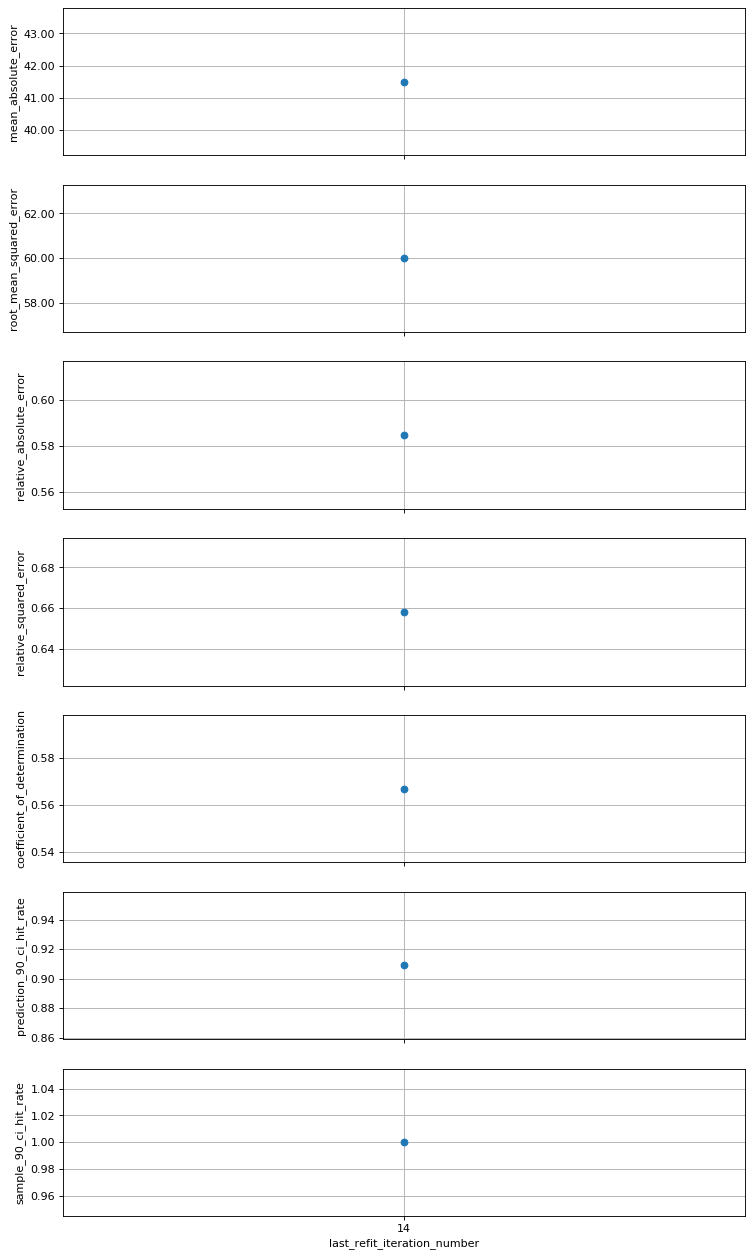

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

gof_df = goodness_of_fit_dataframe
columns_to_plot = [name for name in gof_df.columns.values if name not in ('observation_count', 'prediction_count', 'last_refit_iteration_number')]
num_plots = len(columns_to_plot)
fig, axs = plt.subplots(num_plots, figsize=(11, 20), dpi=80, sharex=True)

for i, column in enumerate(columns_to_plot):
    axs[i].plot(gof_df['last_refit_iteration_number'], gof_df[column], marker='o', label=column)
    axs[i].set_ylabel(column)
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axs[i].set_xticks(gof_df['last_refit_iteration_number'])
    axs[i].grid(True)
    if i == num_plots - 1:
        axs[i].set_xlabel('last_refit_iteration_number')
        
fig.show()

In [34]:
global_values.tracer.dump_trace_to_file(r"E:\code\new_mlos\source\Mlos.Python\temp\meta_optimizer.json")